In [5]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pysal as ps

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [6]:
# read in cleaned data
df = gp.read_file('data/citi_stations_new/citi_stations_new.shp')
df = df.dropna()
df.head()

,bike,citi_ct,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers
0,0.0,50,685.0,5.745953,1.546906,POINT (988123.4138740347 209229.9971760014),108788.666667,97876,424.0,93.333333,996.666667,189.277778,491,24,0.081701,1270.277778
1,0.0,71,818.0,6.473488,2.296295,POINT (987101.0798574506 194275.467285947),69243.000000,14196,97.0,496.000000,1477.000000,224.666667,321,6,0.058556,134.666667
2,0.0,85,1810.0,5.505930,2.147639,POINT (986869.9855586613 220363.1983025315),95493.500000,69145,1160.5,75.500000,3100.500000,780.000000,530,0,0.456680,246.500000
3,0.0,8,435.0,6.331385,4.757612,POINT (979668.4382618705 174911.8334632019),22645.000000,497,75.0,54.000000,767.000000,64.500000,255,5,0.175152,182.500000
4,0.0,68,322.0,6.854920,2.787957,POINT (985048.5833977 193860.8698218935),186348.000000,3676,27.0,84.000000,667.000000,43.000000,3180,2,0.230439,45.500000


In [7]:
# combine no vehicle units into one column
df['no_vehicle'] = df['no_vehic_1'] + df['no_vehicle']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['log_workers'] = np.log10(df['workers'])
df['log_residents'] = np.log10(df['residents'])
df['log_rides'] = np.log10(df['n_rides'])

# get rid of outlier
df = df[df['n_rides'] < 50000]
df.head()

,bike,citi_ct,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,log_workers,log_residents,log_rides
1,0.0,71,818.0,6.473488,2.296295,POINT (987101.0798574506 194275.467285947),69243.0,14196,97.0,593.0,1477.0,224.666667,321,6,0.058556,134.666667,41.906052,2.129260,2.351539,4.152166
3,0.0,8,435.0,6.331385,4.757612,POINT (979668.4382618705 174911.8334632019),22645.0,497,75.0,129.0,767.0,64.500000,255,5,0.175152,182.500000,40.086442,2.261263,1.809560,2.696356
4,0.0,68,322.0,6.854920,2.787957,POINT (985048.5833977 193860.8698218935),186348.0,3676,27.0,111.0,667.0,43.000000,3180,2,0.230439,45.500000,46.989924,1.658011,1.633468,3.565376
5,0.0,124,408.5,5.741747,2.276212,POINT (994127.766081233 220193.7785254942),274175.0,16573,101.0,304.0,1136.5,119.458333,3016,5,0.202353,214.166667,32.967653,2.330752,2.077216,4.219401
6,0.0,80,532.0,3.831091,2.629047,POINT (995583.0175083855 202633.6594084637),35735.0,127,244.0,304.0,909.0,92.666667,3014,0,0.400509,105.666667,14.677256,2.023938,1.966924,2.103804


### Simple Model to test this LEHD OD value

In [8]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     59.42
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           1.36e-22
Time:                        17:46:23   Log-Likelihood:                -3252.9
No. Observations:                 315   AIC:                             6512.
Df Residuals:                     312   BIC:                             6523.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.015e+04   3373.955      5.971      0.000      1.35e+04  2.68e+04
dist_towor -5262.9315    532.538     -9.883      0.000     -6310.751 -4215.112
dist_tohom   740.2134    485.975      1.523      0.129      -215.988  1696.415
==============================================================================
Omnibus:                       72.120   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.182
Skew:                           1.187   Prob(JB):                     4.91e-32
Kurtosis:                       5.313   Cond. No.                         49.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Extensive Model

In [9]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom + dist_tohom2 + subway_dis + bike + commute_ti + \
income_pc + no_vehicle + pop + residents + subway_ct + workers', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     14.10
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           3.12e-23
Time:                        17:46:24   Log-Likelihood:                -3233.7
No. Observations:                 315   AIC:                             6493.
Df Residuals:                     302   BIC:                             6542.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    2.188e+04   1.01e+04      2.169      0.031      2027.144  4.17e+04
dist_towor  -4349.5327    642.034     -6.775      0.000     -5612.959 -3086.106
dist_tohom   -832.0979   4078.205     -0.204      0.838     -8857.395  7193.200
dist_tohom2    73.4609    414.700      0.177      0.860      -742.607   889.529
subway_dis   -995.8540   3025.724     -0.329      0.742     -6950.027  4958.319
bike           -2.8819     33.881     -0.085      0.932       -69.554    63.790
commute_ti      5.7083      2.800      2.038      0.042         0.198    11.219
income_pc       0.0123      0.011      1.123      0.262        -0.009     0.034
no_vehicle      3.6752      5.149      0.714      0.476        -6.457    13.808
pop            -6.3801      1.796     -3.552      0.000        -9.914    -2.846
residents      12.5607      3.865      3.250      0.001         4.955    20.166
subway_ct     148.2517    107.076      1.385      0.167       -62.458   358.962
workers         0.2704      0.490      0.552      0.581        -0.693     1.234
==============================================================================
Omnibus:                       50.817   Durbin-Watson:                   1.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.325
Skew:                           0.841   Prob(JB):                     2.22e-23
Kurtosis:                       5.263   Cond. No.                     2.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
df.corr()

,bike,citi_ct,commute_ti,dist_tohom,dist_towor,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,log_workers,log_residents,log_rides
bike,1.000000,-0.127741,0.064767,-0.045537,0.122994,-0.174218,-0.090224,0.020190,-0.020235,0.018940,-0.109077,0.111301,-0.035628,0.092933,-0.020062,-0.046828,-0.151706,-0.088662,-0.075417
citi_ct,-0.127741,1.000000,0.054937,0.109061,-0.199797,0.528826,0.149908,-0.010543,0.113435,0.061247,0.317261,0.193733,-0.078459,-0.038778,0.006218,0.070608,0.201402,0.266989,0.145244
commute_ti,0.064767,0.054937,1.000000,0.198323,-0.250999,0.061596,0.150897,0.688146,0.772975,0.803520,0.433169,-0.023174,0.099843,-0.090101,0.165966,0.210012,0.198118,0.452832,0.128610
dist_tohom,-0.045537,0.109061,0.198323,1.000000,-0.291354,0.393318,0.221719,0.146720,0.291861,0.092377,0.203091,0.007914,0.202448,0.082475,0.241272,0.993320,0.477165,0.068937,0.015094
dist_towor,0.122994,-0.199797,-0.250999,-0.291354,1.000000,-0.437580,-0.520061,-0.226511,-0.390951,-0.168630,-0.152070,0.107420,-0.363036,0.126390,-0.144054,-0.301089,-0.422047,-0.089891,-0.404142
income_pc,-0.174218,0.528826,0.061596,0.393318,-0.437580,1.000000,0.334293,-0.185126,0.063912,-0.083167,0.132601,0.057487,0.189592,-0.097481,0.120644,0.376144,0.430864,0.070494,0.240279
n_rides,-0.090224,0.149908,0.150897,0.221719,-0.520061,0.334293,1.000000,0.098746,0.218560,-0.006991,0.237508,-0.192672,0.289036,-0.147769,0.121707,0.223749,0.307713,0.186269,0.720829
no_vehic_1,0.020190,-0.010543,0.688146,0.146720,-0.226511,-0.185126,0.098746,1.000000,0.907288,0.796442,0.496977,0.069647,0.061483,-0.001860,0.186758,0.158215,0.172649,0.512488,0.023330
no_vehicle,-0.020235,0.113435,0.772975,0.291861,-0.390951,0.063912,0.218560,0.907288,1.000000,0.821933,0.578930,0.002420,0.173061,-0.090034,0.250411,0.302931,0.325453,0.584623,0.120610
pop,0.018940,0.061247,0.803520,0.092377,-0.168630,-0.083167,-0.006991,0.796442,0.821933,1.000000,0.412075,0.000222,-0.001091,-0.024996,0.146098,0.104691,0.124776,0.458327,-0.027927


This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

### Another model following simple feature selection

In [11]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom + dist_tohom2 + subway_dis + workers + residents', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     22.73
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           3.56e-22
Time:                        17:46:36   Log-Likelihood:                -3246.0
No. Observations:                 315   AIC:                             6506.
Df Residuals:                     308   BIC:                             6532.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1.705e+04   9716.534      1.754      0.080     -2071.889  3.62e+04
dist_towor  -4938.2974    537.207     -9.193      0.000     -5995.358 -3881.237
dist_tohom   1371.4826   4029.740      0.340      0.734     -6557.820  9300.786
dist_tohom2   -87.0115    411.374     -0.212      0.833      -896.470   722.447
subway_dis  -4550.7341   2624.173     -1.734      0.084     -9714.309   612.841
workers         0.3032      0.474      0.640      0.523        -0.629     1.235
residents       9.4726      3.074      3.082      0.002         3.424    15.521
==============================================================================
Omnibus:                       60.813   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.422
Skew:                           1.018   Prob(JB):                     1.93e-26
Kurtosis:                       5.208   Cond. No.                     2.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

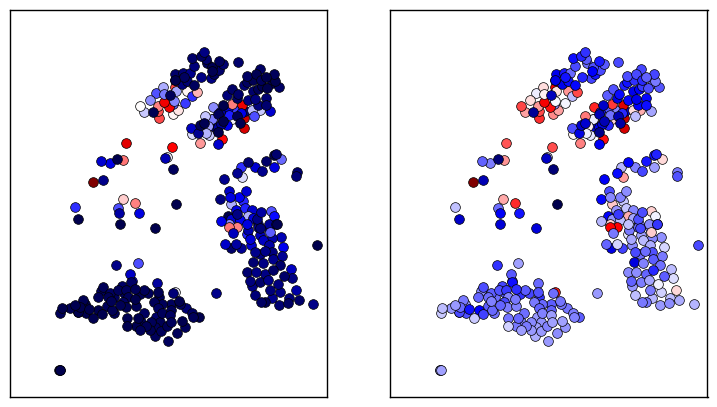

In [24]:
f1, ax = plt.subplots(ncols = 2, figsize=(9,5))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
df.plot(column = 'n_rides', cmap = 'seismic', ax = ax[0], markersize = 7)
#df.plot(column = 'dist_tohom', cmap = 'seismic', ax = ax[1], markersize = 7)
df.plot(column = 'resid', cmap = 'seismic', ax = ax[1], markersize = 7)

In [15]:
# spatial regression

if not os.path.exists('data/for_sreg/'):
    os.makedirs('data/for_sreg/')
    
df.to_file('data/for_sreg/for_sreg.shp')

w = ps.knnW_from_shapefile('data/for_sreg/for_sreg.shp', k = 2)
sp_reg = ps.spreg.ML_Lag(df[['n_rides']].as_matrix(), df[['dist_towor', 'dist_tohom', 'dist_tohom2', \
                                                          'subway_dis', 'workers', 'residents']].as_matrix(), w = w)
print sp_reg.summary

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         315
Mean dependent var  :   6593.3175                Number of Variables   :           8
S.D. dependent var  :   8695.8716                Degrees of Freedom    :         307
Pseudo R-squared    :      0.3497
Spatial Pseudo R-squared:  0.3263
Sigma-square ML     :49053215.173                Log likelihood        :   -3238.889
S.E of regression   :    7003.800                Akaike info criterion :    6493.777
                                                 Schwarz criterion     :    6523.798

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

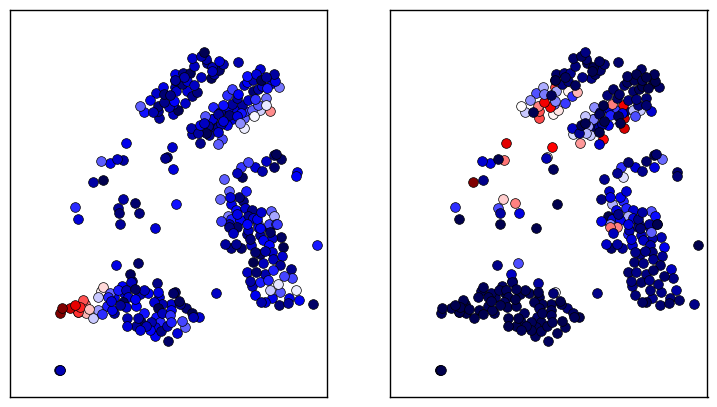

In [22]:
f1, ax = plt.subplots(ncols = 2, figsize=(9,5))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
df.plot(column = 'subway_dis', cmap = 'seismic', ax = ax[0], markersize = 7)
df.plot(column = 'n_rides', cmap = 'seismic', ax = ax[1], markersize = 7)